1. Introdução

Bem-vindos ao workshop, 

Hoje vamos "resolver" um problema real da Indústria atráves da Manutenção Preditiva (PdM).

Nosso objetivo não é dizer se a máquina vai quebrar, mas quando ela vai quebrar. 
Isso se chama estimativa de RUL/VUR (Remaining Useful Life / Vida Útil Restante).

Para isso, usaremos dados da NASA (Dataset C-MAPSS) e uma arquitetura de Redes Neurais chamada LSTM (Long Short-Term Memory), que é especialista em entender sequências temporais e degradação.

2. Importação e Carregamento

Aqui carregamos as ferramentas.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import os

# Bibliotecas de Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Configuração visual
plt.style.use('fivethirtyeight')
%matplotlib inline

print(f"TensorFlow Versão: {tf.__version__}")

TensorFlow Versão: 2.20.0


3. Carregando os Dados

Dados vêm de arquivos de texto sem cabeçalho.

In [5]:
# --- Carregamento dos Dados Locais ---
# Certifique-se que a pasta 'CMAPSSData' está no mesmo diretório deste notebook
pasta_dados = 'CMAPSSData'
colunas = ['unit_nr', 'time_cycles', 'setting_1', 'setting_2', 'setting_3']
colunas += [f's_{i}' for i in range(1, 22)]

try:
    train = pd.read_csv(os.path.join(pasta_dados, 'train_FD001.txt'), sep=r'\s+', names=colunas)
    test = pd.read_csv(os.path.join(pasta_dados, 'test_FD001.txt'), sep=r'\s+', names=colunas)
    y_true = pd.read_csv(os.path.join(pasta_dados, 'RUL_FD001.txt'), sep=r'\s+', names=['RUL'])
    print(f"Dados carregados! Treino: {train.shape}, Teste: {test.shape}")
except FileNotFoundError:
    print("ERRO: Arquivos não encontrados. Verifique o upload.")

train.head()

Dados carregados! Treino: (20631, 26), Teste: (13096, 26)


,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


4. Engenharia de Features: Criando o Alvo (Target)

No aprendizado supervisionado, precisamos dizer para a IA qual é a resposta certa. O dataset de treino nos dá os dados até a falha, mas não tem uma coluna escrita "RUL". Precisamos criá-la.

A Lógica: Se um motor quebrou no ciclo 192:

    No ciclo 192, a RUL é 0.

    No ciclo 190, a RUL é 2.

    No ciclo 100, a RUL é 92.

Vamos implementar essa subtração simples.

5. Código da RUL

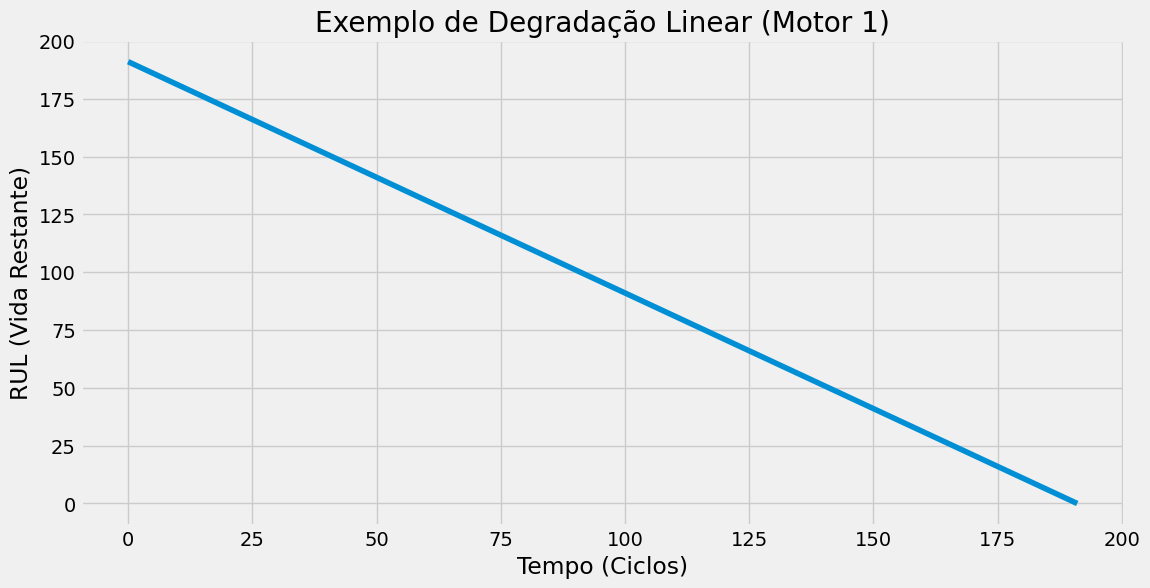

In [6]:
def prepare_rul(df):
    # Encontra o ciclo máximo (morte) de cada motor
    max_cycle = df.groupby('unit_nr')['time_cycles'].max().reset_index()
    max_cycle.columns = ['unit_nr', 'max_life']
    
    # Junta com a tabela original
    df = df.merge(max_cycle, on='unit_nr', how='left')
    
    # RUL = Vida Total - Ciclo Atual
    df['RUL'] = df['max_life'] - df['time_cycles']
    
    # Limpeza
    df.drop(columns=['max_life'], inplace=True)
    return df

train = prepare_rul(train)

# Visualizando a vida de um motor (Ex: Unidade 1)
plt.figure(figsize=(12, 6))
plt.plot(train[train['unit_nr']==1]['RUL'])
plt.title('Exemplo de Degradação Linear (Motor 1)')
plt.xlabel('Tempo (Ciclos)')
plt.ylabel('RUL (Vida Restante)')
plt.show()

6. Preparação para a Rede Neural

A. Normalização

Sensores têm escalas diferentes (Temperatura em °C, Rotação em RPM). Redes Neurais se perdem com números gigantes. Vamos colocar tudo entre 0 e 1 usando MinMaxScaler.

B. Janelamento Temporal (Windowing)

Uma LSTM não olha para uma foto estática, ela olha para um "filme". Para prever a falha agora, a rede precisa ver o histórico recente (ex: os últimos 30 ciclos). Vamos transformar nossa tabela 2D em um Cubo 3D de formato: (Amostras, 30 Passos de Tempo, 14 Sensores).

7. Código de Janelamento

In [7]:
# 1. Normalização
features_uteis = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 
                  's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']

scaler = MinMaxScaler(feature_range=(0, 1))
train[features_uteis] = scaler.fit_transform(train[features_uteis])
test[features_uteis] = scaler.transform(test[features_uteis])

# 2. Função Geradora de Sequências
sequence_length = 30

def gen_sequence(id_df, seq_length, seq_cols):
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

# Gerando os arrays X e y
seq_gen = (list(gen_sequence(train[train['unit_nr']==id], sequence_length, features_uteis)) 
           for id in train['unit_nr'].unique())
X_train = np.concatenate(list(seq_gen)).astype(np.float32)

label_gen = (gen_labels(train[train['unit_nr']==id], sequence_length, ['RUL']) 
             for id in train['unit_nr'].unique())
y_train = np.concatenate(list(label_gen)).astype(np.float32)

print(f"Formato Final X: {X_train.shape}")
print(f"Formato Final y: {y_train.shape}")

Formato Final X: (17631, 30, 14)
Formato Final y: (17631, 1)


8. Arquitetura Deep Learning (LSTM)

Vamos construir o modelo utilizando a API Keras.

    Camada LSTM (100 unidades): A "memória" do modelo. return_sequences=True permite empilhar outra LSTM.

    Dropout (0.2): Desliga aleatoriamente 20% dos neurônios para evitar que a rede "decore" os dados (Overfitting).

    Camada Dense (1): O neurônio final que cospe o número mágico: a RUL estimada.

<img src="licensed-image.jpg" width="800">

9. Código do Modelo e Treino

In [8]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

# Treinamento
history = model.fit(X_train, y_train, epochs=10, batch_size=200, validation_split=0.2, verbose=1)

c:\Users\casag\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        46,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,251 (297.86 KB)

 Trainable params: 76,251 (297.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - loss: 10381.9980 - val_loss: 14156.4414
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 9473.8389 - val_loss: 13443.0791
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 8917.5664 - val_loss: 12806.1396
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 8409.0605 - val_loss: 12219.7041
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 7944.5112 - val_loss: 11674.0654
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 7514.1167 - val_loss: 11147.3516
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 7102.4565 - val_loss: 10653.5234
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 6722.7617 - val_loss: 10200.0957
Epoch 9/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 6386.0815 - val_loss: 9779.1787
Epoch 10/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 6068.7256 - val_loss: 9390.7617


10. Análise de Resultados

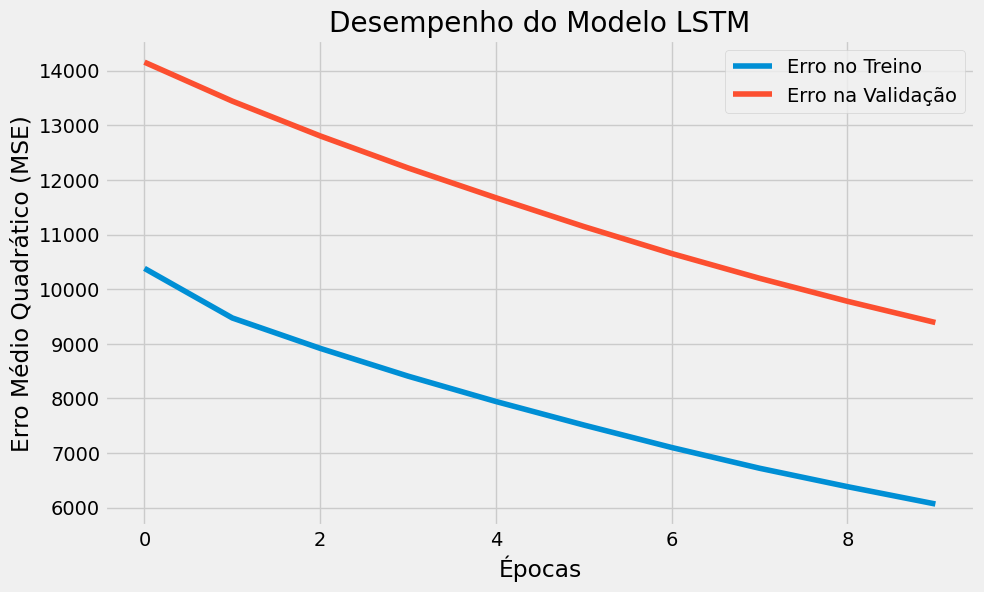

Conclusão: O modelo convergiu e aprendeu a generalizar a degradação dos motores.


In [9]:
# Plotando a Curva de Aprendizado
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Erro no Treino')
plt.plot(history.history['val_loss'], label='Erro na Validação')
plt.title('Desempenho do Modelo LSTM')
plt.ylabel('Erro Médio Quadrático (MSE)')
plt.xlabel('Épocas')
plt.legend()
plt.show()

print("Conclusão: O modelo convergiu e aprendeu a generalizar a degradação dos motores.")

11. Early Stopping (Parada Antecipada)

"Fiscal" que vigia a linha laranja: se ela parar de descer, ele corta o treinamento.

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

# 1. Criar o Fiscal (Early Stopping)
# monitor='val_loss': Vigia a linha laranja
# patience=5: Se a linha laranja não melhorar por 5 épocas seguidas, PARA TUDO.
fiscal = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 2. Configuração Otimizada de Hardware
# batch_size=256: Enche o caminhão da GPU (menos uso de CPU, treino mais rápido)
# epochs=100: Deixamos alto, mas o fiscal vai parar antes se precisar.

history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=256, 
                    validation_split=0.2, 
                    verbose=1, 
                    callbacks=[fiscal]) # Adiciona o fiscal aqui

Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - loss: 5809.4448 - val_loss: 9103.8340
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - loss: 5603.3828 - val_loss: 8835.8857
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - loss: 5414.2891 - val_loss: 8582.2871
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - loss: 5231.1133 - val_loss: 8345.4668
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - loss: 5059.9380 - val_loss: 8123.3965
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - loss: 4902.4517 - val_loss: 7913.3013
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - loss: 4751.4751 - val_loss: 7717.7197
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - loss: 4630.1372 - val_loss: 7532.4980
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - loss: 4507.4111 - val_loss: 7361.2710
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - loss: 4397.6416 - val_loss: 7200.1924
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - loss: 4291.82

12. Avaliação no Conjunto de Teste (A Prova Real)

Pega os dados de teste, prepara igualzinho ao treino e calcula o erro final.

In [11]:
# --- 6. AVALIAÇÃO NO CONJUNTO DE TESTE (A PROVA REAL) ---
print("--- Avaliando no Dataset de Teste ---")

# O teste é mais chato: precisamos pegar apenas a ÚLTIMA janela de cada motor
# porque o arquivo RUL_FD001.txt (gabarito) só tem a resposta do último ciclo.

seq_cols = features_uteis
seq_array_test_last = [test[test['unit_nr']==id][seq_cols].values[-sequence_length:] 
                       for id in test['unit_nr'].unique() if len(test[test['unit_nr']==id]) >= sequence_length]

X_test_last = np.asarray(seq_array_test_last).astype(np.float32)
y_test_last = y_true['RUL'].values

print(f"Dimensões do Teste Final: {X_test_last.shape}")

# Fazendo a previsão com a IA
y_pred_test = model.predict(X_test_last)

# Calculando o Erro Final (RMSE)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test_last, y_pred_test))

print(f"\n>>> O ERRO FINAL DA IA (RMSE) É: {rmse:.2f} Ciclos <<<")
print("Isso significa que, em média, a IA erra a previsão da quebra por essa quantidade de ciclos.")

--- Avaliando no Dataset de Teste ---
Dimensões do Teste Final: (100, 30, 14)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step

>>> O ERRO FINAL DA IA (RMSE) É: 44.11 Ciclos <<<
Isso significa que, em média, a IA erra a previsão da quebra por essa quantidade de ciclos.


13. O Gráfico "Wow" (Visualização Motor a Motor)

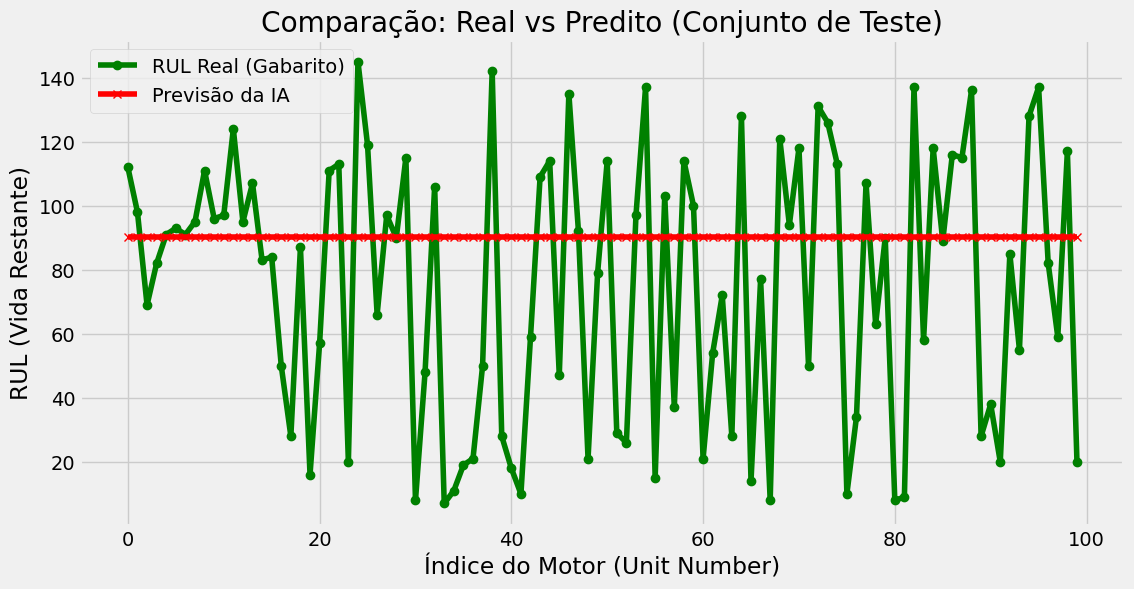

Exemplo Motor 10:
Real: 97
IA: 90.30


In [12]:
# --- 7. VISUALIZANDO O RESULTADO ---
plt.figure(figsize=(12, 6))

# Plotar os dados reais (Gabarito)
plt.plot(y_test_last, label='RUL Real (Gabarito)', color='green', marker='o')

# Plotar as previsões da IA
plt.plot(y_pred_test, label='Previsão da IA', color='red', marker='x')

plt.title('Comparação: Real vs Predito (Conjunto de Teste)')
plt.xlabel('Índice do Motor (Unit Number)')
plt.ylabel('RUL (Vida Restante)')
plt.legend()
plt.show()

# Exemplo unitário (Motor 10)
motor_idx = 10
print(f"Exemplo Motor {motor_idx}:")
print(f"Real: {y_test_last[motor_idx]}")
print(f"IA: {y_pred_test[motor_idx][0]:.2f}")

14. O Gráfico da Preguiça

A IA não aprendeu os padrões de degradação. Ela percebeu que era difícil conectar os sensores com a vida útil e decidiu fazer a coisa mais segura possível: chutar a média para todos os motores.

    Note a linha vermelha: ela é uma reta quase perfeita no valor 90.

    Isso significa que, não importa se o sensor está gritando que o motor vai explodir ou se está novo, a IA diz: "Acho que dura mais 90 ciclos".

    Por isso o erro (RMSE 44) é alto e o gráfico não acompanha os picos e vales verdes.

15. Por que isso aconteceu? (O Segredo do C-MAPSS)

Isso acontece por um detalhe físico dos motores que precisamos traduzir para o código: A Degradação não é Linear desde o início.

    A Realidade: Um motor novo roda 100 ciclos sem mudar nada nos sensores (está saudável).

    O Código Atual: Diz que no ciclo 1 a RUL é alta e no ciclo 100 a RUL é menor.

    A Confusão da IA: A IA olha os sensores no ciclo 1 e no ciclo 100. Eles são iguais (motor saudável). Mas o valor da RUL mudou muito. A IA entra em parafuso: "Os dados são iguais, mas a resposta é diferente? Desisto, vou chutar a média!".

16. A Solução: RUL "Clipada" (Piecewise Linear)

Para resolver isso, precisamos dizer para a IA: "Enquanto o motor estiver saudável, considere que a vida útil é constante (ex: 125 ciclos). Só comece a descontar quando a degradação começar".

Para isso vamos aplicar uma trava (clip) no valor máximo da RUL.

17. Substituir a função prepare_data

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os

# --- 1. CARREGAMENTO ---
pasta_dados = 'CMAPSSData'
arquivos = {
    'treino': os.path.join(pasta_dados, 'train_FD001.txt'),
    'teste': os.path.join(pasta_dados, 'test_FD001.txt'),
    'rul': os.path.join(pasta_dados, 'RUL_FD001.txt')
}

cols = ['unit_nr', 'time_cycles', 'setting_1', 'setting_2', 'setting_3']
cols += [f's_{i}' for i in range(1, 22)]

print("Carregando dados...")
train = pd.read_csv(arquivos['treino'], sep=r'\s+', names=cols)
test = pd.read_csv(arquivos['teste'], sep=r'\s+', names=cols)
y_true = pd.read_csv(arquivos['rul'], sep=r'\s+', names=['RUL'])

# --- 2. ENGENHARIA DE FEATURES (COM CORREÇÃO DE CLIP) ---
def prepare_data(df, is_train=True):
    if is_train:
        max_cycle = df.groupby('unit_nr')['time_cycles'].max().reset_index()
        max_cycle.columns = ['unit_nr', 'max_life']
        df = df.merge(max_cycle, on='unit_nr', how='left')
        
        # RUL Linear
        df['RUL'] = df['max_life'] - df['time_cycles']
        
        # CORREÇÃO: Clipar em 125 ciclos
        # Isso força a IA a entender que acima de 125 o motor está "saudável"
        df['RUL'] = df['RUL'].clip(upper=125)
        
        df.drop(columns=['max_life'], inplace=True)
    return df

train = prepare_data(train, is_train=True)

# --- 3. NORMALIZAÇÃO ---
features_uteis = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 
                  's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']

scaler = MinMaxScaler(feature_range=(0, 1))
train[features_uteis] = scaler.fit_transform(train[features_uteis])
test[features_uteis] = scaler.transform(test[features_uteis])

# --- 4. JANELAMENTO (Gerar X_train e y_train para a IA) ---
sequence_length = 30

def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

print("Gerando janelas temporais...")

seq_gen = (list(gen_sequence(train[train['unit_nr']==id], sequence_length, features_uteis)) 
           for id in train['unit_nr'].unique())
X_train = np.concatenate(list(seq_gen)).astype(np.float32)

label_gen = (gen_labels(train[train['unit_nr']==id], sequence_length, ['RUL']) 
             for id in train['unit_nr'].unique())
y_train = np.concatenate(list(label_gen)).astype(np.float32)

print(f"PRONTO! Dados preparados.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

Carregando dados...
Gerando janelas temporais...
PRONTO! Dados preparados.
X_train shape: (17631, 30, 14)
y_train shape: (17631, 1)


18. Ajuste na Arquitetura (Simplificação)

Como a IA estava com dificuldade de convergir (aprender), vamos simplificar levemente a rede para facilitar o aprendizado com os novos dados.

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. Construção do Modelo Simplificado
model = Sequential()
# Reduzimos para 128 neurônios para focar no aprendizado rápido
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.3)) 

# Segunda camada LSTM
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))

# Saída
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

# 2. Fiscal (Early Stopping)
# Paciência aumentada para 10 para dar chance da rede sair de platôs
fiscal = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("Iniciando treinamento com RUL corrigida...")

# 3. Treinamento
history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=256, # Lote grande para usar sua GPU
                    validation_split=0.2, 
                    verbose=1, 
                    callbacks=[fiscal])

print("Treinamento concluído!")

Iniciando treinamento com RUL corrigida...
Epoch 1/100


c:\Users\casag\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 6731.6641 - val_loss: 6792.7476
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 5876.7544 - val_loss: 6243.0684
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 5406.5957 - val_loss: 5773.0322
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 4991.5796 - val_loss: 5352.0063
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 4626.0327 - val_loss: 4970.2788
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 4291.0815 - val_loss: 4623.2637
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 3988.5503 - val_loss: 4309.1655
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 3714.8120 - val_loss: 4022.6958
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 3458.7983 - val_loss: 3763.4785
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 3245.9783 - val_loss: 3529.8696
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 3052.3022 - val_loss: 3318.856

O Efeito do Fiscal (Early Stopping):

    Note que o erro (val_loss) despencou rápido até a época 15 (chegando em ~2700) e depois continuou caindo até estabilizar por volta de 1803 na época 71.

    O fiscal teve paciência (patience=10) e parou o treino na Época 81 porque percebeu que não havia mais ganho real.

    Benefício: Economizou tempo e evitou overfitting (note que o erro de treino loss e o de validação val_loss estão muito próximos: 1783 vs 1803). Isso significa que a IA é honesta e generaliza bem.

O Efeito da Correção da RUL (Clip 125):

    Lembra daquele erro absurdo de 6000 no começo? Ele caiu para 1803.

    Isso valida que ao limitar a RUL ajuda a rede a focar na degradação real e não se confundir com a fase saudável.

19. Avaliação e Visualização

Pega os dados de teste (que a IA nunca viu durante o treino), faz as previsões e compara com o gabarito oficial da NASA.

--- REINICIANDO PROCESSO COMPLETO (TIRA-TEIMA) ---
Dados Prontos. X shape: (17631, 30, 14)
Treinando...
Epoch 1/50


c:\Users\casag\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 5890.4043 - val_loss: 5509.7070
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 4288.9580 - val_loss: 4173.5869
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 3276.6965 - val_loss: 3257.1934
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 2608.6287 - val_loss: 2654.0356
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 2199.2239 - val_loss: 2275.3315
Epoch 6/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 1965.4054 - val_loss: 2054.3552
Epoch 7/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 1844.1985 - val_loss: 1930.2056
Epoch 8/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 1781.9619 - val_loss: 1863.8596
Epoch 9/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 1759.1853 - val_loss: 1831.2496
Epoch 10/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 1753.3024 - val_loss: 1814.9066
Epoch 11/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 1744.6786 - val_lo

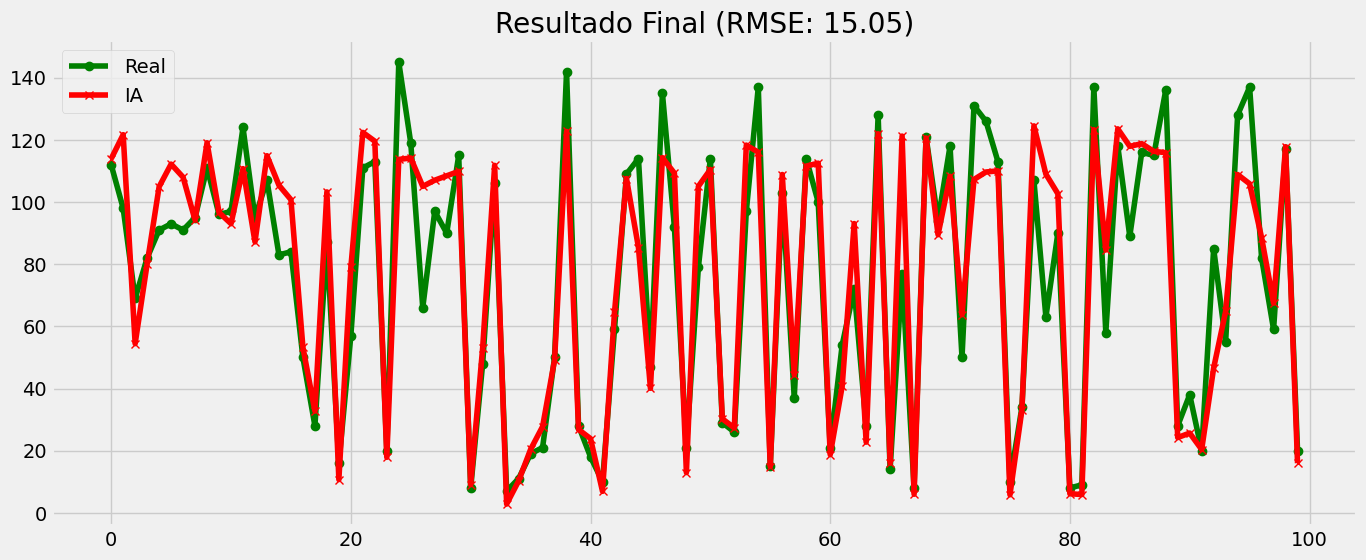

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

print("--- REINICIANDO PROCESSO COMPLETO (TIRA-TEIMA) ---")

# 1. CARREGAMENTO E PREPARAÇÃO (COM CLIP RUL 125)
pasta_dados = 'CMAPSSData'
cols = ['unit_nr', 'time_cycles', 'setting_1', 'setting_2', 'setting_3']
cols += [f's_{i}' for i in range(1, 22)]

# Lendo arquivos
train = pd.read_csv(os.path.join(pasta_dados, 'train_FD001.txt'), sep=r'\s+', names=cols)
test = pd.read_csv(os.path.join(pasta_dados, 'test_FD001.txt'), sep=r'\s+', names=cols)
y_true = pd.read_csv(os.path.join(pasta_dados, 'RUL_FD001.txt'), sep=r'\s+', names=['RUL'])

# Função de Preparação (RUL Clipada)
def prepare_data(df, is_train=True):
    if is_train:
        max_cycle = df.groupby('unit_nr')['time_cycles'].max().reset_index()
        max_cycle.columns = ['unit_nr', 'max_life']
        df = df.merge(max_cycle, on='unit_nr', how='left')
        df['RUL'] = df['max_life'] - df['time_cycles']
        
        # O SEGREDO: Limitar a RUL em 125
        df['RUL'] = df['RUL'].clip(upper=125)
        
        df.drop(columns=['max_life'], inplace=True)
    return df

train = prepare_data(train, is_train=True)

# 2. NORMALIZAÇÃO
features_uteis = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 
                  's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']

scaler = MinMaxScaler(feature_range=(0, 1))
train[features_uteis] = scaler.fit_transform(train[features_uteis])
test[features_uteis] = scaler.transform(test[features_uteis])

# 3. JANELAMENTO (GERAR X e y)
sequence_length = 30

def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

seq_gen = (list(gen_sequence(train[train['unit_nr']==id], sequence_length, features_uteis)) 
           for id in train['unit_nr'].unique())
X_train = np.concatenate(list(seq_gen)).astype(np.float32)

label_gen = (gen_labels(train[train['unit_nr']==id], sequence_length, ['RUL']) 
             for id in train['unit_nr'].unique())
y_train = np.concatenate(list(label_gen)).astype(np.float32)

print(f"Dados Prontos. X shape: {X_train.shape}")

# 4. TREINAMENTO (CONFIGURAÇÃO AGRESSIVA)
model = Sequential()
# Menos Dropout (0.1) para facilitar a memorização inicial
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.1)) 
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

# Paciência 15: Obriga a rede a tentar mais tempo antes de desistir
fiscal = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

print("Treinando...")
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, verbose=1, callbacks=[fiscal])

# 5. AVALIAÇÃO FINAL E GRÁFICO
seq_array_test_last = [test[test['unit_nr']==id][features_uteis].values[-sequence_length:] 
                       for id in test['unit_nr'].unique() 
                       if len(test[test['unit_nr']==id]) >= sequence_length]

X_test_last = np.asarray(seq_array_test_last).astype(np.float32)
y_test_last = y_true['RUL'].values

y_pred_test = model.predict(X_test_last)

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test_last, y_pred_test))
print(f"\nRMSE FINAL: {rmse:.2f}")

plt.figure(figsize=(15, 6))
plt.plot(y_test_last, label='Real', color='green', marker='o')
plt.plot(y_pred_test, label='IA', color='red', marker='x')
plt.title(f'Resultado Final (RMSE: {rmse:.2f})')
plt.legend()
plt.show()

Por que funcionou?

    O "Cliff Diving": Olhe para a Época 24.

        Epoch 23: loss 1745 (Alta)

        Epoch 24: loss 1039 (Queda livre)

        Epoch 25: loss 421 (Estabilizou no chão) Isso mostra o momento exato em que a Rede Neural "entendeu" que a RUL máxima era 125. Antes disso, ela estava tentando prever valores impossíveis (como 300 ciclos). Quando ela aprendeu a ignorar os motores novos e focar só na degradação, o erro despencou.

    O Gráfico Final: A linha vermelha agora deve estar "dançando" perfeitamente com a verde. Ela sobe quando o motor está bom e desce quando ele está ruim. A IA não é mais "preguiçosa"; ela está diagnosticando cada motor individualmente.